# Quantization

https://pytorch.org/blog/introduction-to-quantization-on-pytorch/

https://pytorch.org/docs/stable/quantization.html

https://www.onnxruntime.ai/docs/

https://towardsdatascience.com/why-you-should-convert-your-nlp-pipelines-to-onnx-2c4a3433325f#:~:text=ONNX%20Runtime's%20built%2Din%20graph,integers%20from%20floating%20point%20decimals).

https://www.cortex.dev/post/40x-nlp-inference-with-hugging-face-and-onnx

https://towardsdatascience.com/how-to-accelerate-and-compress-neural-networks-with-quantization-edfbbabb6af7

https://channel9.msdn.com/Shows/AI-Show/Faster-and-Lighter-Model-Inference-with-ONNX-Runtime-from-Cloud-to-Client

## Introduction
The idea of distillation and pruning is to reduce the computational and memory cost of a model by reducing the number of computations necessary by reducing layers or dropping individual weights. Quantization takes a different approach and instead of reducing the number of computations aims at making every computation more efficient. This can be achieved by reducing the precision of the floating variables which are by default 32-bits in most deep learning frameworks. You have probably encountered this trick when training large neural networks with modern graphics cards. One can train neural networks with _half-precision_ (16-bits) which can significantly speed up training while reducing the graphics memory utilization.

In contrast to half-precision, quantization of a model we usually involves transforming the operations from float32 to int8. This reduces the model size and computation speed by up to a factor of **four**! The actual speedup depends on the hardware and runtime you are using to execute your model and can vary but a speedup between 2-4x is expected.

That sounds great, but we don't get that much speedup for free. Changing the precision for all computations in our model introduces small disturbances at each point in the model's computational graph which can compound and affect the model's performance. There are several ways to quantize a model which all have pros and cons. In the following sections we will briefly introduce them.

### Dynamic Quantization
When using dynamic quantization nothing is changed during training and the adaptations are only performed during inference. Like in all quantization methods we will discuss the weights of the model are converted to int8 ahead of time. In addition to the weights also the model's activations are also quantized. This happens during the forward pass for inference, hence the name dynamic quantization. This means that all the matrix multiplications can be calculated with highly optimized int8 functions. Of all the quantization methods discussed here is dynamic quantization the simplest one. However, with dynamic quantization the activations are written and read to memory in floating point format. This conversion between integer and floating point format can be a performance bottleneck. The next section discusses a method that adresses that issue.

### Static Quantization
Instead of just computing the quantization of the activations on the fly one could save the conversion to floating point if the quantization scheme of the activations were pre-computed. Static quantization achieves this by observing the activations patterns on a representative sample of the data ahead of inference time. The ideal quantization scheme is calculated and then saved. This enables us to never convert the values between int8 and float32 resulting in an additional speedup of the computations. However, this requires access to a good data sample and introduces an additional step in the pipeline, since we now need to train, determine the quantization scheme, and finally can perform inference. There is one aspect that also static quantization does not adress and this is the discrepancy between the precision during training and inference which leads to a performance drop in the model's metrics (e.g. accuracy). This can be improved by adapting the training loop as discussed in the next section.

### Quantization Aware Training (QAT)
The affect of quantization can be effectively simulated during training by _"fake"_ quantization of the float32 values. Instead of using int8 during training the float32 values are rounded to mimic the effect of quantization. This is done during both the forward and backward pass and improves performance in terms of model metrics over static and dynamic quantization.

### Quantization of Transformers
The main bottleneck for transformers is the compute and memory bandwidth for the weights of the model, since transformer models have an enormous amount of weightsl. For this reason is dynamic quantization the best approach for transformer like models in NLP. In smaller vision models the limiting factor is the memory bandwidth of the activations which is why static quantization is generally used and QAT in cases where the performance drops are too significant.

## Imports

In [ ]:
# run before onnx import
from os import environ
from psutil import cpu_count
environ["OMP_NUM_THREADS"] = str(cpu_count(logical=True))
environ["OMP_WAIT_POLICY"] = 'ACTIVE'

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from time import time
from contextlib import contextmanager
from tqdm import trange
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## ONNX Imports & Utils

In [ ]:
from transformers.convert_graph_to_onnx import convert, quantize
from onnxruntime_tools import optimizer
from onnxruntime_tools.transformers.onnx_model_bert import BertOptimizationOptions
from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions, get_all_providers

def create_model_for_provider(model_path, provider): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

    session = InferenceSession(model_path, options, providers=[provider])
    session.disable_fallback()
    return session

class ONNXPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, prompt):
        model_inputs = self.tokenizer(prompt, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}
        return self.model.run(None, inputs_onnx)

## Timing Utils

In [ ]:
@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()
    buffer.append(end - start)

def time_pipeline(pipe, prompt='Transformers are great! ', n=100, multiplier=1):
    prompt = prompt*multiplier
    time_buffer = []
    
    #warmup
    for _ in range(10):
        _ = pipe(prompt)
    
    #timed run
    for _ in trange(n):
        with track_infer_time(time_buffer):
            _ = pipe(prompt)
    return 1000*np.mean(time_buffer), 1000*np.std(time_buffer)

In [ ]:
onnx_opset = 12
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

## PyTorch, CPU

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
times_mean, times_std = dict(), dict()

In [ ]:
name = 'cpu, full'
pipe = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
times_mean[name], times_std[name] = time_pipeline(pipe)

100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


In [ ]:
model_quantized = torch.quantization.quantize_dynamic(model,
                                                      {torch.nn.Linear},
                                                      dtype=torch.qint8)

In [ ]:
name = 'cpu, quant'
pipe = pipeline('sentiment-analysis', model=model_quantized, tokenizer=tokenizer)
times_mean[name], times_std[name] = time_pipeline(pipe)

100%|██████████| 100/100 [00:02<00:00, 47.38it/s]


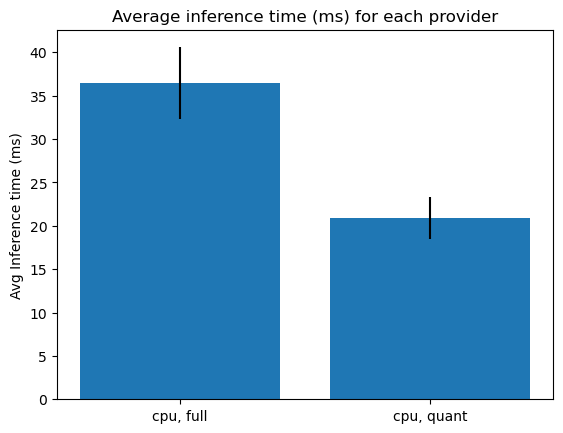

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(times_mean.keys(), times_mean.values(), yerr=times_std.values())
plt.show()

## ONNX and ONNX Runtime
The ONNX framework sets up a unified format to save machine learning models from TensorFlow, PyTorch all the way to Scikit-Learn. In addition, it also offers the ONNX Runtime which is an auxiliary framework to run these models efficiently on a wide range of hardware. Because ONNX optimizes the computational graph of the model and the runtime is compatible with a wide range of hardware this leads to a significant speedup over running the vanilla PyTorch model. Like PyTorch offers ONNX quantization methods to further improve the models memory footprint and inference speed.

In [ ]:
!rm -rf onnx/

convert(framework="pt", model=model_name, output=Path("onnx/model.onnx"), opset=onnx_opset)

opt_options = BertOptimizationOptions('bert')
opt_options.enable_embed_layer_norm = False

opt_model = optimizer.optimize_model(
    'onnx/model.onnx',
    'bert', 
    num_heads=12,
    hidden_size=768,
    optimization_options=opt_options)
opt_model.save_model_to_file('bert.opt.onnx')

ONNX opset version set to: 12
Loading pipeline (model: nlptown/bert-base-multilingual-uncased-sentiment, tokenizer: nlptown/bert-base-multilingual-uncased-sentiment)
Creating folder onnx
Using framework PyTorch: 1.6.0+cu92
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input token_type_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Found output output_1 with shape: {0: 'batch'}
Ensuring inputs are in correct order
position_ids is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask', 'token_type_ids']


/opt/conda/envs/fastai/lib/python3.8/site-packages/transformers/models/bert/modeling_bert.py:194: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]
/opt/conda/envs/fastai/lib/python3.8/site-packages/transformers/modeling_utils.py:1759: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert all(


In [ ]:
name = 'onnx, cpu, full'
provider = "CPUExecutionProvider"
model_onnx = create_model_for_provider("onnx/model.onnx", provider)
pipe = ONNXPipeline(model_onnx, tokenizer)

times_mean[name], times_std[name] = time_pipeline(pipe)

100%|██████████| 100/100 [00:01<00:00, 64.57it/s]


In [ ]:
name = 'onnx, cpu, quant'

quantized_model_path = quantize(Path("bert.opt.onnx"))
quantized_model = create_model_for_provider(quantized_model_path.as_posix(), "CPUExecutionProvider")

pipe = ONNXPipeline(quantized_model, tokenizer)
times_mean[name], times_std[name] = time_pipeline(pipe)

As of onnxruntime 1.4.0, models larger than 2GB will fail to quantize due to protobuf constraint.
This limitation will be removed in the next release of onnxruntime.
         Please use quantize_static for static quantization, quantize_dynamic for dynamic quantization.
Quantized model has been written at bert.onnx: ✔


100%|██████████| 100/100 [00:00<00:00, 130.40it/s]


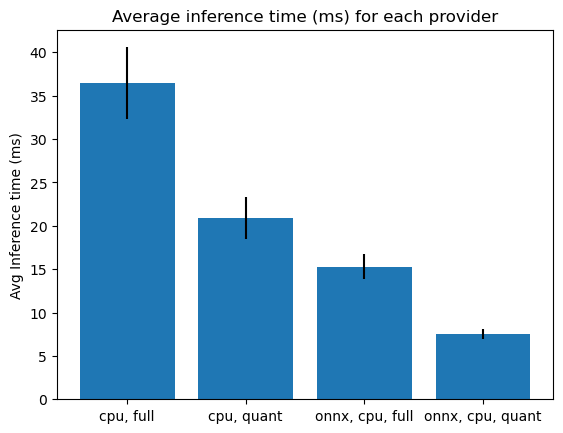

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(times_mean.keys(), times_mean.values(), yerr=times_std.values())
plt.show()

In [ ]:
times_mean["cpu, full"]/times_mean["onnx, cpu, quant"]

4.822253925305406

In [ ]:
%%timeit
prompt='Transformers are great!'
model_inputs = tokenizer(prompt, return_tensors="pt")
inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}

121 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
from torch.onnx.symbolic_helper import _onnx_master_opset, _onnx_stable_opsets
_onnx_master_opset, _onnx_stable_opsets

(10, [7, 8, 9, 10, 11, 12])

## Install

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade torch==1.6.0 torchvision==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!{sys.executable} -m pip install --upgrade onnxruntime==1.4.0
!{sys.executable} -m pip install -i https://test.pypi.org/simple/ ort-nightly
!{sys.executable} -m pip install --upgrade onnxruntime-tools
!{sys.executable} -m pip install onnx psutil

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.6.0 in /opt/conda/envs/fastai/lib/python3.8/site-packages (1.6.0+cu92)
Requirement already up-to-date: torchvision==0.7.0 in /opt/conda/envs/fastai/lib/python3.8/site-packages (0.7.0+cu92)


In [ ]:
import sys
!{sys.executable} -m pip freeze

adal==1.2.5
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1605217004767/work
async-generator==1.10
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
azure-cognitiveservices-search-imagesearch==2.0.0
azure-common==1.1.26
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1600454382015/work
blis==0.4.1
brotlipy==0.7.0
catalogue @ file:///home/conda/feedstock_root/build_artifacts/catalogue_1605613584677/work
certifi==2020.11.8
cffi @ file:///home/conda/feedstock_root/build_artifacts/cffi_1602537222527/work
chardet @ file:///home/conda/feedstock_root/build_artifacts/chardet_1602255302199/work
click==7.1.2
coloredlogs==15.0
cryptography @ file:///home/conda/feedstock_root/build_artifacts/cryptography_1604179079864/work
cycler==0.10.0
cymem @ file:///home/conda/feedstock_root/build_artifacts

The following list contains the relevant packages (to the best of my knowledge). It could be that onnxruntime and ort-nightly are the same thing.

onnx==1.8.0

onnxruntime==1.6.0

ort-nightly==1.6.0.dev202101251

onnxruntime-tools==1.5.2

torch==1.6.0+cu92

torchvision==0.7.0+cu92
